# Workshop (2) - 14 Aug, 2025

# Dataset Interpretation – Cybersecurity Exercise Recommendation Project

## 1. Project Context
From the project description:
- **Goal:** Recommend cybersecurity exercises tailored to an organisation’s context, threats, and APT landscape.
- **Phase 1:** Item-based recommendation using **exercise metadata** (TTPs, difficulty, scope, etc.) to find similar drills.
- **Datasets:**  
  - `orgs_full.csv` → Organisation profiles (context).  
  - `exercises_full.csv` → Exercise library (content).

---

## 2. `orgs_full.csv` – Organisation Profiles
Each row = **one organisation** and its current threat landscape.

| Column | Meaning in Project |
|--------|--------------------|
| **ORGID** | Unique org identifier; used to link with exercise history. |
| **Industry** *(Attack Campaign Type)* | Main attack theme or most relevant threat campaign. |
| **Region** *(Attack Origin)* | Geographic region where the threats typically originate. |
| **Size** | Organisation size (Small, Medium, Large). |
| **SecurityBudget** | Scale of security investment (Low, Medium, High). |
| **PrimarySecurityTeam** | Who operates security: In-house, Outsourced, or Hybrid. |
| **Maturity** | 1–5 score for security process maturity. |
| **Complexity** | 1–5 score for system/infrastructure complexity. |
| **ExerciseFrequency** | Number of drills run per year. |
| **Threats** | Primary threats faced by the organisation (semicolon-separated). |
| **TTPs** | MITRE ATT&CK techniques relevant to the org’s threat profile. |
| **Aims** | Skills or capabilities the org wants to test (tools, malware, adversary groups). |

**Phase 1 Use:**  
Filters or weights to prioritise exercises with matching TTPs, Threats, and Aims.

---

## 3. `exercises_full.csv` – Exercise Metadata
Each row = **one cyber training exercise**.

| Column | Meaning in Project |
|--------|--------------------|
| **EXID** | Unique exercise identifier. |
| **ExCreation** | Creation date or version/date of the exercise. |
| **ExThreat** | Main threat scenario simulated (e.g., Phishing, Ransomware). |
| **ExTTPs** | MITRE ATT&CK techniques tested (semicolon-separated). |
| **ExCategories** | Broad classification (simulation, tabletop, red team). |
| **ExGroups** | Associated threat actor groups (e.g., APT28, FIN7). |
| **ExSoftware** | Tools/malware/software used in the scenario. |
| **ExStructure** | How the exercise is organised (single-day, multi-phase). |
| **ExMaturity** | 1–5 scale — intended audience’s security maturity level. |
| **ExComplexity** | 1–5 scale — exercise complexity. |
| **ExLength** | Duration of the exercise (minutes/hours). |
| **ExAudience** | Target participants (SOC analysts, management, mixed). |
| **ExTradeCraftIntra** | Score for intra-team tradecraft skills. |
| **ExTradeCraftInter** | Score for inter-team tradecraft skills. |

**Phase 1 Use:**  
- Combine **textual fields** (`ExThreat`, `ExTTPs`, `ExCategories`, `ExGroups`, `ExSoftware`, `ExStructure`, `ExAudience`) into one text string for TF-IDF vectorisation.  
- **Numeric fields** (`ExMaturity`, `ExComplexity`, `ExLength`, `ExTradeCraftIntra`, `ExTradeCraftInter`) can be normalised and added to feature vectors or used for filtering.

---

## 4. How They Work Together
- **`orgs_full.csv`** = Context → “What the org faces & what they want to prepare for.”
- **`exercises_full.csv`** = Content → “The available training exercises.”
- **Phase 1 workflow:**
  1. Build a Document-Term Matrix (DTM) from `exercises_full.csv` using TF-IDF on relevant metadata.
  2. Compute cosine similarity between exercise vectors.
  3. Recommend **new exercises** that closely match:
     - A given **target exercise**, or
     - An **organisation’s past exercises** (average similarity across history).

---


In [2]:
# Importing necesssary libraries
import pandas as pd
import re

# Read the dataset
df_orgs = pd.read_csv("orgs_full.csv")
df_exs  = pd.read_csv("exercises_full.csv")

# Load your mapping CSV (adjust the filename/paths/column names if needed)
df_ttps = pd.read_csv("ENTERPRISE_ATTACK_TECHNIQUES.CSV") 

# Info and data types of the datasets & columns
df_orgs.info(), df_exs.info(), df_ttps.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ORGID                40 non-null     int64 
 1   Industry             40 non-null     object
 2   Region               40 non-null     object
 3   Size                 40 non-null     object
 4   SecurityBudget       40 non-null     object
 5   PrimarySecurityTeam  40 non-null     object
 6   Maturity             40 non-null     int64 
 7   Complexity           40 non-null     int64 
 8   ExerciseFrequency    40 non-null     int64 
 9   Threats              40 non-null     object
 10  TTPs                 40 non-null     object
 11  Aims                 40 non-null     object
dtypes: int64(4), object(8)
memory usage: 3.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  -----

(None, None, None)

Lets see the few records of the datasets 

In [28]:
df_orgs.head()

,ORGID,Industry,Region,Size,SecurityBudget,PrimarySecurityTeam,Maturity,Complexity,ExerciseFrequency,Threats,TTPs,Aims
0,1,Ransomware,South America,Small,Medium,In-house,4,4,120,Remote Access Trojan,Signed Binary Proxy Execution;Network Service ...,APT10;Maze;Supply Chain;Application Window Dis...
1,2,Supply Chain,Europe,Large,Medium,In-house,1,5,180,DDoS;Web Shell,Command and Scripting Interpreter;Service Stop...,XMRig;FIN7;Registry Run Keys;Cobalt Strike
2,3,Insider Threat,North America,Small,Medium,Outsourced,4,4,90,Banking Trojan;Ransomware;Crypto Miner,Data Exfiltration Over Web Service;Network Ser...,Remote Access Trojan;ASPXSpy;Remcos;Crypto Miner
3,4,Banking Trojan,Africa,Medium,Low,Hybrid,1,4,300,Phishing;Banking Trojan,Spearphishing Attachment;Signed Binary Proxy E...,Indicator Removal;Evilginx;NanoCore;Web Shell
4,5,Banking Trojan,Africa,Medium,High,In-house,4,5,180,Phishing,Data Staged;Unsecured Credentials;User Executi...,XMRig;njRAT;APT34;Command and Scripting Interp...


In [29]:
df_exs.head()

,EXID,ExCreation,ExThreat,ExTTPs,ExCategories,ExGroups,ExSoftware,ExStructure,ExMaturity,ExComplexity,ExLength,ExAudience,ExTradeCraftIntra,ExTradeCraftInter
0,1,2021-12-07,Ransomware,Credential Dumping;Process Injection;Access To...,Dark web;Malware,Wizard Spider;FIN6;TA505;UNC1878;DarkSide;REvi...,TrickBot,Notification;Response;Impact;Validation;Develo...,5,1,45,Network;SecOps,0.000000,0.750000
1,2,2023-07-02,Banking Trojan,Malicious File;Persistence;Valid Accounts,Data breach;Financial,Dridex Group;Evil Corp;Carbanak;Ursnif Operators,Dridex;TrickBot,Impact;Notification;Exfiltration;Detection;Med...,4,5,75,Media;SecOps,0.666667,1.000000
2,3,2022-12-26,Ransomware,Password Spraying;File and Directory Discovery...,Crypto;Impact,Wizard Spider;FIN6;TA505;UNC1878;DarkSide;REvi...,TrickBot;Maze,Exfiltration;Impact;Response;Validation;Media;...,2,5,30,Media;SecOps,0.000000,0.666667
3,4,2021-04-26,Remote Access Trojan;Crypto Miner,Drive-by Compromise;Credential Access;Maliciou...,C2;APT;Supply Chain,APT33;FIN7;APT41;APT3;Turla;Rocke;Panda;Blue M...,NanoCore;QuasarRAT;PlugX;XMRig;Kinsing;CoinMiner,Notification;Media;Developments;Response;Legal...,4,3,165,Network;SecOps,0.428571,0.714286
4,5,2022-10-20,Data Breach,Execution;Process Injection;Brute Force,Crypto;Botnet,APT29;FIN4;Charming Kitten;APT10;APT1;Cobalt G...,Empire;Mimikatz;BloodHound,Media;Exfiltration;Response;Detection;Validati...,1,5,150,Media;SecOps,0.333333,0.666667


In [30]:
df_ttps.head()

,Name,Id
0,Extra Window Memory Injection,T1055.011
1,Scheduled Task,T1053.005
2,Socket Filters,T1205.002
3,Indicator Removal from Tools,T1066
4,Archive via Utility,T1560.001


In [31]:
# Lambda: normalize one column name
norm_col = lambda c: str(c).strip().lower().replace(" ", "_")
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=norm_col)

# Lets clean the text specially multivalued separated by ;
# splits → trims → removes blanks → sorts → rejoins
def normalize_list_col(s: pd.Series):
    return (s.fillna('')
             .str.split(';')
             .apply(lambda xs: ';'.join(sorted(x.strip() for x in xs if x.strip()))))

# Lets fix the case of the categorical variables
# Convert text to lower case.
def normalise_case(s: pd.Series):
    return (s.astype(str)
         .str.strip()
         .str.replace(r'\s+', ' ', regex=True)
         .str.lower())

In [32]:
# first of all lets normalise the columna names and make it consistent among all dataset.. best practices..
df_orgs = normalize_columns(df_orgs)
df_exs = normalize_columns(df_exs)
df_ttps = normalize_columns(df_ttps)

df_orgs.columns.values, df_exs.columns.values, df_ttps.columns.values

(array(['orgid', 'industry', 'region', 'size', 'securitybudget',
        'primarysecurityteam', 'maturity', 'complexity',
        'exercisefrequency', 'threats', 'ttps', 'aims'], dtype=object),
 array(['exid', 'excreation', 'exthreat', 'exttps', 'excategories',
        'exgroups', 'exsoftware', 'exstructure', 'exmaturity',
        'excomplexity', 'exlength', 'exaudience', 'extradecraftintra',
        'extradecraftinter'], dtype=object),
 array(['name', 'id'], dtype=object))

In [33]:
# In this step lets filter out the categorical/text columns which has object dtypes 
cat_cols_orgs = df_orgs.select_dtypes(include='object').columns
cat_cols_exs = df_exs.select_dtypes(include='object').columns
cat_cols_ttps = df_ttps.select_dtypes(include='object').columns

cat_cols_orgs, cat_cols_exs, cat_cols_ttps

(Index(['industry', 'region', 'size', 'securitybudget', 'primarysecurityteam',
        'threats', 'ttps', 'aims'],
       dtype='object'),
 Index(['excreation', 'exthreat', 'exttps', 'excategories', 'exgroups',
        'exsoftware', 'exstructure', 'exaudience'],
       dtype='object'),
 Index(['name', 'id'], dtype='object'))

In [34]:
# If you look at the features like Threats, Aims, TTPs it is matibvalued separated with semicolon
# Lets normalise it with normalise_list_cols method that -
# (1) replaces any Nan values with empty string '', 
# (2) splits the string by ; to create a list, 
# (3) strips leading and trailing spaces
# (4) sorts aplhabetically and
# (5) joins back into single string.

df_orgs['threats'] = normalize_list_col(df_orgs['threats'])
df_orgs['aims'] = normalize_list_col(df_orgs['aims'])
df_orgs['ttps'] = normalize_list_col(df_orgs['ttps'])

df_exs['exttps']     = normalize_list_col(df_exs['exttps'])
df_exs['exgroups']   = normalize_list_col(df_exs['exgroups'])
df_exs['exsoftware'] = normalize_list_col(df_exs['exsoftware'])
df_exs['excategories'] = normalize_list_col(df_exs['excategories'])

In [35]:
# calling the above normalise_case function to apply for all categorical variables
for col in cat_cols_orgs:
    df_orgs[col] = normalise_case(df_orgs[col])

for col in cat_cols_exs:
        df_exs[col] = normalise_case(df_exs[col])

for col in cat_cols_ttps:
        df_ttps[col] = normalise_case(df_ttps[col])

In [36]:
# Checking if the dataset has any duplicate entries
'''
df_orgs['orgid'].duplicated().any(), df_exs['exid'].duplicated().any()
'''

"\ndf_orgs['orgid'].duplicated().any(), df_exs['exid'].duplicated().any()\n"

In [37]:
# There is the creation date field in exercise dataset
# Might use this exercise creation date field so converting it to datetime

'''
df_exs['excreation'] = pd.to_datetime(df_exs['excreation'], errors='coerce')
print(df_exs['excreation'].info())
'''

"\ndf_exs['excreation'] = pd.to_datetime(df_exs['excreation'], errors='coerce')\nprint(df_exs['excreation'].info())\n"

In [38]:
# Now lets check if there is any missing values.

print(df_orgs.isna().sum())
print()
print(df_exs.isna().sum())
print()
print(df_ttps.isna().sum())

orgid                  0
industry               0
region                 0
size                   0
securitybudget         0
primarysecurityteam    0
maturity               0
complexity             0
exercisefrequency      0
threats                0
ttps                   0
aims                   0
dtype: int64

exid                 0
excreation           0
exthreat             0
exttps               0
excategories         0
exgroups             0
exsoftware           0
exstructure          0
exmaturity           0
excomplexity         0
exlength             0
exaudience           0
extradecraftintra    0
extradecraftinter    0
dtype: int64

name    0
id      0
dtype: int64


In [39]:
# Lets see the unique values preent in each categorical variable

orgs_unique_val = df_orgs[cat_cols_orgs].nunique().sort_values(ascending=False)
exe_unique_val  = df_exs[cat_cols_exs].nunique().sort_values(ascending=False)

print(orgs_unique_val)
print()
print(exe_unique_val)

ttps                   40
aims                   40
threats                30
industry               10
region                  6
size                    3
securitybudget          3
primarysecurityteam     3
dtype: int64

excreation      30
exttps          30
exsoftware      30
exstructure     30
excategories    29
exthreat        20
exgroups        20
exaudience      17
dtype: int64


In [40]:
df_ttps.head()

,name,id
0,extra window memory injection,t1055.011
1,scheduled task,t1053.005
2,socket filters,t1205.002
3,indicator removal from tools,t1066
4,archive via utility,t1560.001


In [41]:
df_ttps['name_norm'] = (df_ttps['name']
                        .str.strip()
                        .str.lower()
                        .str.replace(r'\s+', ' ', regex=True))

In [42]:
df_ttps.head()

,name,id,name_norm
0,extra window memory injection,t1055.011,extra window memory injection
1,scheduled task,t1053.005,scheduled task
2,socket filters,t1205.002,socket filters
3,indicator removal from tools,t1066,indicator removal from tools
4,archive via utility,t1560.001,archive via utility


In [43]:
# Build fast lookups
NAME2ID = dict(zip(df_ttps['name'], df_ttps['id']))

In [44]:
NAME2ID

{'extra window memory injection': 't1181',
 'scheduled task': 't1053.005',
 'socket filters': 't1205.002',
 'indicator removal from tools': 't1027.005',
 'archive via utility': 't1560.001',
 'vnc': 't1021.005',
 'windows management instrumentation': 't1047',
 'malicious shell modification': 't1156',
 'screen capture': 't1113',
 'fileless storage': 't1027.011',
 'bootkit': 't1542.003',
 'boot or logon initialization scripts': 't1037',
 'adversary-in-the-middle': 't1557',
 'system owner/user discovery': 't1033',
 'acquire infrastructure': 't1583',
 'rundll32': 't1085',
 'container and resource discovery': 't1613',
 'serverless': 't1584.007',
 'hidden window': 't1564.003',
 'lc_load_dylib addition': 't1546.006',
 'standard encoding': 't1132.001',
 'embedded payloads': 't1027.009',
 'plist modification': 't1547.011',
 'pluggable authentication modules': 't1556.003',
 'revert cloud instance': 't1536',
 'histcontrol': 't1148',
 'gather victim host information': 't1592',
 'digital certificate

In [70]:
# EDA to know the dateset better

# cyber posture vs maturity
#exground is mitre attack catetogy
#maturity links to impact in CVEs

#maturity in excercise datsaet depesnds on TTPs and frewuency and organisatio is different
#cluster organisation based on threat groups
#develop a metrics to measure sucess 
#extradecraft similarity score inside and outside ..

from collections import Counter

def explode_counts(df, col):
    counts = Counter()
    df[col].dropna().apply(lambda x: counts.update([t.strip() for t in str(x).split(";")]))
    return pd.DataFrame(counts.most_common(), columns=[col, "count"])

print(explode_counts(df_exs, "exthreat").head(10))
print(explode_counts(df_exs, "exttps").head(10))

print(explode_counts(df_orgs, "threats").head(10))
print(explode_counts(df_orgs, "ttps").head(10))



               exthreat  count
0        banking trojan      6
1           data breach      6
2                  ddos      6
3            ransomware      5
4             web shell      5
5  remote access trojan      4
6        insider threat      4
7          supply chain      4
8          crypto miner      3
9              phishing      2
                              exttps  count
0                    defense evasion      7
1                          execution      7
2                     valid accounts      6
3                          discovery      6
4                        persistence      5
5                       exfiltration      5
6                             impact      5
7               privilege escalation      5
8                       masquerading      5
9  command and scripting interpreter      4
                threats  count
0             web shell     14
1  remote access trojan     13
2              phishing     11
3                  ddos      8
4        banking tro

In [75]:
from sklearn.preprocessing import MultiLabelBinarizer

def onehot_multivalued(series):
    series = series.fillna("").apply(lambda x: [s.strip() for s in x.split(";") if s.strip()])
    mlb = MultiLabelBinarizer()
    return pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)

ex_threat_ohe = onehot_multivalued(df_exs["exthreat"])
print(ex_threat_ohe.head())

   banking trojan  crypto miner  data breach  ddos  insider threat  phishing  \
0               0             0            0     0               0         0   
1               1             0            0     0               0         0   
2               0             0            0     0               0         0   
3               0             1            0     0               0         0   
4               0             0            1     0               0         0   

   ransomware  remote access trojan  supply chain  web shell  
0           1                     0             0          0  
1           0                     0             0          0  
2           1                     0             0          0  
3           0                     1             0          0  
4           0                     0             0          0  


In [64]:
for c in ["exthreat","exttps","excategories","exaudience","exstructure","exgroups"]:
    uniques = explode_counts(df_exs, c)
    print(f"{c}: {len(uniques)} unique, top5 = {uniques.head(5).to_dict('records')}")


exthreat: 10 unique, top5 = [{'exthreat': 'banking trojan', 'count': 6}, {'exthreat': 'data breach', 'count': 6}, {'exthreat': 'ddos', 'count': 6}, {'exthreat': 'ransomware', 'count': 5}, {'exthreat': 'web shell', 'count': 5}]
exttps: 49 unique, top5 = [{'exttps': 'defense evasion', 'count': 7}, {'exttps': 'execution', 'count': 7}, {'exttps': 'valid accounts', 'count': 6}, {'exttps': 'discovery', 'count': 6}, {'exttps': 'persistence', 'count': 5}]
excategories: 15 unique, top5 = [{'excategories': 'botnet', 'count': 10}, {'excategories': 'financial', 'count': 9}, {'excategories': 'ransom negotiation', 'count': 9}, {'excategories': 'crypto', 'count': 8}, {'excategories': 'web', 'count': 8}]
exaudience: 7 unique, top5 = [{'exaudience': 'secops', 'count': 20}, {'exaudience': 'network', 'count': 15}, {'exaudience': 'media', 'count': 9}, {'exaudience': 'exec', 'count': 6}, {'exaudience': 'legal', 'count': 5}]
exstructure: 10 unique, top5 = [{'exstructure': 'response', 'count': 22}, {'exstruc

array([[<Axes: title={'center': 'exmaturity'}>,
        <Axes: title={'center': 'excomplexity'}>],
       [<Axes: title={'center': 'exlength'}>,
        <Axes: title={'center': 'extradecraftintra'}>],
       [<Axes: title={'center': 'extradecraftinter'}>, <Axes: >]],
      dtype=object)

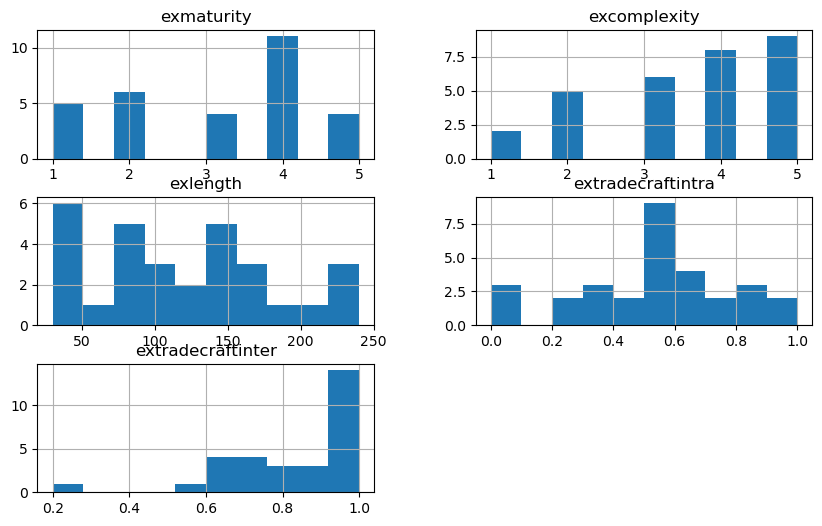

In [66]:
df_exs[["exmaturity","excomplexity","exlength","extradecraftintra","extradecraftinter"]].hist(figsize=(10,6))


In [68]:
def merge_cols(row, cols):
    toks = []
    for c in cols:
        if pd.isna(row.get(c, "")): continue
        vals = [t.strip() for t in str(row[c]).split(";") if t.strip()]
        toks.extend([c.lower()+"_"+t.lower().replace(" ","_") for t in vals])
    return " ".join(toks)

df_exs["threat_doc"] = df_exs.apply(
    lambda r: merge_cols(r, ["exthreat","exgroups"]), axis=1
)

print(df_exs[["exid","exthreat","exgroups","threat_doc"]].head(5))


   exid                           exthreat  \
0     1                         ransomware   
1     2                     banking trojan   
2     3                         ransomware   
3     4  remote access trojan;crypto miner   
4     5                        data breach   

                                            exgroups  \
0  blackmatter;conti;darkside;fin6;lockbit;revil;...   
1   carbanak;dridex group;evil corp;ursnif operators   
2  blackmatter;conti;darkside;fin6;lockbit;revil;...   
3  8220 gang;apt3;apt33;apt41;blue mockingbird;fi...   
4  apt1;apt10;apt29;carbanak;charming kitten;coba...   

                                          threat_doc  
0  exthreat_ransomware exgroups_blackmatter exgro...  
1  exthreat_banking_trojan exgroups_carbanak exgr...  
2  exthreat_ransomware exgroups_blackmatter exgro...  
3  exthreat_remote_access_trojan exthreat_crypto_...  
4  exthreat_data_breach exgroups_apt1 exgroups_ap...  


In [45]:


def split_semicolons(s):
    if pd.isna(s) or not str(s).strip(): return []
    return [p.strip() for p in str(s).split(';') if p.strip()]

def norm_token(x):  # "Banking Trojan" -> "banking_trojan"
    return re.sub(r'\s+', '_', str(x).strip().lower())

def threat_tokens(s):
    return [f"threat_{norm_token(x)}" for x in split_semicolons(s)]

def ttp_tokens(s):
    return [f"ttp_{norm_token(x)}" for x in split_semicolons(s)]


In [46]:
# orgs: threats + ttps
org_docs = (
    df_orgs
    .assign(_tok=lambda d: d['threats'].map(threat_tokens) + d['ttps'].map(ttp_tokens))
    .assign(doc=lambda d: d['_tok'].apply(lambda xs: ' '.join(sorted(set(xs)))))
    [['orgid','doc']]
    .set_index('orgid')['doc']
)

# exercises: exthreat + exttps
ex_docs = (
    df_exs
    .assign(_tok=lambda d: d['exthreat'].map(threat_tokens) + d['exttps'].map(ttp_tokens))
    .assign(doc=lambda d: d['_tok'].apply(lambda xs: ' '.join(sorted(set(xs)))))
    [['exid','doc']]
    .set_index('exid')['doc']
)


In [21]:
org_docs.values

array(['threat_remote_access_trojan ttp_network_service_scanning ttp_signed_binary_proxy_execution',
       'threat_ddos threat_web_shell ttp_command_and_scripting_interpreter ttp_defense_evasion ttp_discovery ttp_exfiltration ttp_service_stop',
       'threat_banking_trojan threat_crypto_miner threat_ransomware ttp_access_token_manipulation ttp_brute_force ttp_bypass_user_account_control ttp_data_exfiltration_over_web_service ttp_data_staged ttp_malicious_file ttp_network_service_scanning ttp_scheduled_task/job ttp_user_execution ttp_windows_management_instrumentation',
       'threat_banking_trojan threat_phishing ttp_command_and_control ttp_execution ttp_phishing ttp_signed_binary_proxy_execution ttp_spearphishing_attachment',
       'threat_phishing ttp_data_staged ttp_masquerading ttp_unsecured_credentials ttp_user_execution',
       'threat_data_breach threat_supply_chain ttp_account_discovery ttp_boot_or_logon_autostart_execution ttp_initial_access ttp_phishing ttp_process_injec

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

corpus = list(org_docs.values) + list(ex_docs.values)
vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), min_df=1,  token_pattern=r"[^ ]+")
vec.fit(corpus)

org_X = vec.transform(org_docs.values)
ex_X  = vec.transform(ex_docs.values)

# feat = vec.get_feature_names_out()
# scale = np.ones_like(feat, dtype=float)
# scale[[f.startswith("ttp_") for f in feat]] = 2.0   # try 2–4×

# org_Xw = org_X @ np.diag(scale)
# ex_Xw  = ex_X  @ np.diag(scale)

sim_df = pd.DataFrame(cosine_similarity(org_X, ex_X),
                      index=org_docs.index, columns=ex_docs.index)

In [59]:
def recommend_for_org(org_id, top_n=5):
    s = sim_df.loc[org_id].sort_values(ascending=False).head(top_n)
    df = s.reset_index()
    df.columns = ['exercise', 'score']   # force names
    df['score'] = df['score'].round(4)
    return df

In [60]:
# Top 5 exercises recommended for Org with ID=1
print(recommend_for_org(1, top_n=5))

   exercise   score
0        14  0.4087
1        21  0.3409
2        27  0.3312
3         9  0.3071
4        28  0.2300


In [54]:
sim_df

exid,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
orgid,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.134201,0.000000,0.000000,0.000000,0.000000,0.307088,0.000000,...,0.340879,0.000000,0.000000,0.126888,0.000000,0.000000,0.331193,0.229964,0.000000,0.000000
2,0.119739,0.000000,0.000000,0.136392,0.000000,0.438763,0.268548,0.000000,0.000000,0.247840,...,0.299366,0.000000,0.000000,0.128959,0.080114,0.332245,0.096895,0.000000,0.204770,0.416989
3,0.209775,0.232729,0.087812,0.258747,0.174048,0.101269,0.163296,0.228171,0.119132,0.000000,...,0.132241,0.332203,0.122110,0.000000,0.101919,0.220989,0.136826,0.134853,0.145095,0.000000
4,0.000000,0.148063,0.000000,0.074775,0.116776,0.000000,0.000000,0.000000,0.171105,0.000000,...,0.000000,0.000000,0.326624,0.086473,0.000000,0.160398,0.322809,0.128132,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173162,0.241957,0.000000,0.000000,...,0.000000,0.290213,0.000000,0.249340,0.147908,0.000000,0.148266,0.000000,0.000000,0.373692
6,0.133617,0.000000,0.000000,0.000000,0.316322,0.000000,0.312249,0.000000,0.000000,0.000000,...,0.000000,0.161160,0.000000,0.000000,0.094986,0.094207,0.115959,0.000000,0.181260,0.119991
7,0.000000,0.102069,0.000000,0.293886,0.093350,0.370809,0.306216,0.000000,0.136780,0.294808,...,0.356098,0.000000,0.297211,0.138935,0.416514,0.145954,0.120016,0.358003,0.139722,0.223988
8,0.122245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.363966,0.149557,0.097875,0.098923,0.197883,0.000000,0.000000
9,0.000000,0.000000,0.215482,0.178131,0.000000,0.000000,0.253888,0.000000,0.000000,0.091735,...,0.110806,0.000000,0.000000,0.168424,0.063710,0.323206,0.069938,0.000000,0.162843,0.080482


In [52]:
# lets check if this recommendaer mataches with training dataset

df_training = pd.read_csv("ratings_train_full.csv")
df_training = normalize_columns(df_training)
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   orgid            177 non-null    int64
 1   exid             177 non-null    int64
 2   exerciseresults  177 non-null    int64
 3   exerciserating   177 non-null    int64
dtypes: int64(4)
memory usage: 5.7 KB


In [57]:
df_training[df_training['orgid'] == 1]

,orgid,exid,exerciseresults,exerciserating
29,1,10,8,2
68,1,26,15,2
101,1,4,6,3
121,1,17,10,2
131,1,15,1,2


In [3]:
df_exs["ExTTPs"]

0     Credential Dumping;Process Injection;Access To...
1             Malicious File;Persistence;Valid Accounts
2     Password Spraying;File and Directory Discovery...
3     Drive-by Compromise;Credential Access;Maliciou...
4               Execution;Process Injection;Brute Force
5     Service Stop;Valid Accounts;Drive-by Compromis...
6     Service Stop;Remote File Copy;Account Discover...
7     User Execution;System Information Discovery;Ap...
8     Application Layer Protocol;Signed Binary Proxy...
9     Credential Access;Discovery;Privilege Escalati...
10    Exfiltration;Command and Scripting Interpreter...
11                                 Phishing;Data Staged
12    Signed Binary Proxy Execution;Exfiltration;Uns...
13    Signed Binary Proxy Execution;Initial Access;P...
14                 User Execution;Phishing;Exfiltration
15    Unsecured Credentials;Obfuscated Files or Info...
16    Execution;Scheduled Task/Job;Persistence;Comma...
17       Web Shell;Defense Evasion;Privilege Esc

In [8]:
def normalize_list_col(s: pd.Series):
    return (s.fillna('')
             .str.split(';')
             .apply(lambda xs: ' '.join(sorted(x.strip() for x in xs if x.strip()))))

In [9]:
normalize_list_col(df_exs["ExTTPs"])

0     Access Token Manipulation Credential Dumping D...
1             Malicious File Persistence Valid Accounts
2     File and Directory Discovery Password Spraying...
3     Command and Scripting Interpreter Credential A...
4               Brute Force Execution Process Injection
5     Discovery Drive-by Compromise Service Stop Val...
6     Account Discovery Exfiltration Impact Remote F...
7     Application Layer Protocol System Information ...
8     Application Layer Protocol Signed Binary Proxy...
9     Credential Access Discovery Privilege Escalati...
10    Command and Scripting Interpreter Discovery Ex...
11                                 Data Staged Phishing
12    Exfiltration OS Credential Dumping Scheduled T...
13    Defense Evasion Impact Initial Access Network ...
14                 Exfiltration Phishing User Execution
15    Discovery Execution Initial Access Obfuscated ...
16    Command and Control Defense Evasion Execution ...
17       Defense Evasion Privilege Escalation We

In [11]:
def split_semicolons(s):
    if pd.isna(s) or not str(s).strip(): return []
    return [p.strip() for p in str(s).split(';') if p.strip()]

def norm_token(x):  # "Banking Trojan" -> "banking_trojan"
    return re.sub(r'\s+', '_', str(x).strip().lower())

def threat_tokens(s):
    return [f"threat_{norm_token(x)}" for x in split_semicolons(s)]

def ttp_tokens(s):
    return [f"ttp_{norm_token(x)}" for x in split_semicolons(s)]

In [14]:
org_docs = (
    df_orgs
    .assign(_tok=lambda d: d['Threats'].map(threat_tokens) + d['TTPs'].map(ttp_tokens))
    .assign(doc=lambda d: d['_tok'].apply(lambda xs: ' '.join(sorted(set(xs)))))
    [['ORGID','doc']]
    .set_index('ORGID')['doc']
)

In [22]:
org_docs.values

array(['threat_remote_access_trojan ttp_network_service_scanning ttp_signed_binary_proxy_execution',
       'threat_ddos threat_web_shell ttp_command_and_scripting_interpreter ttp_defense_evasion ttp_discovery ttp_exfiltration ttp_service_stop',
       'threat_banking_trojan threat_crypto_miner threat_ransomware ttp_access_token_manipulation ttp_brute_force ttp_bypass_user_account_control ttp_data_exfiltration_over_web_service ttp_data_staged ttp_malicious_file ttp_network_service_scanning ttp_scheduled_task/job ttp_user_execution ttp_windows_management_instrumentation',
       'threat_banking_trojan threat_phishing ttp_command_and_control ttp_execution ttp_phishing ttp_signed_binary_proxy_execution ttp_spearphishing_attachment',
       'threat_phishing ttp_data_staged ttp_masquerading ttp_unsecured_credentials ttp_user_execution',
       'threat_data_breach threat_supply_chain ttp_account_discovery ttp_boot_or_logon_autostart_execution ttp_initial_access ttp_phishing ttp_process_injec